In [26]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;}</style>')
%load_ext version_information
%version_information pandas

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.7.1 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.2.0
OS Darwin 18.2.0 x86_64 i386 64bit
pandas 0.23.4
Mon Apr 29 07:15:04 2019 PDT

# Goalie Pull Bayes Optimize

 - Parse the goalie pull stats we need
 
### This script is for the current format: *2007/2008* and later

## Parse HTML Stats Table

In [27]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
import re
import datetime
import time
from collections import OrderedDict
import glob
from tqdm import tqdm_notebook
from colorama import Fore, Style

### Helper functions

In [28]:
def is_int(x):
    try:
        int(x)
        return True
    except:
        return False

def parse_time(s):
    _s = s.copy()
    _s = _s.apply(lambda x:
        datetime.datetime.strptime(x.split(' ')[0], '%M:%S')
    )
    _s = _s.apply(lambda x:
        datetime.timedelta(
        hours=x.hour,
        minutes=x.minute,
        seconds=x.second,
        microseconds=x.microsecond
    ))
    return _s

def parse_team(s):
    _s = s.copy()
    # Add '.' as a hack in case _s is empty
    _s = (_s + '.').str.split().apply(lambda x: x[0])
    return _s

def parse_date(s):
    _s = s.copy()
    
    # invalid parsing will be set as NaT
    _s = pd.to_datetime(_s, errors='coerce')

    '''
     _s = _s.apply(lambda x: (re.search(',(.*)', x.text.splitlines()[2])
                             .group(1)
                             .strip()))
     _s = _s.apply(lambda x: datetime.datetime\
                             .strptime(x.strip(), '%B %d, %Y'))
    '''
    
    return _s

def goalie_pull_timedelta(s1, s2):
    out = []
    for d1, d2 in zip(s1.values, s2.values):
        try:
            o = d1 - d2
        except:
            o = float('nan')
        out.append(o)
    return out

### Main Functions

In [29]:
def get_game_df(
    soup,
    local_html=True,
) -> pd.DataFrame:
    '''
    Returns the parsed HTML stats table for some game and returns
    a DataFrame.
    
    local_html : bool
        Set True if using local HTML file. Otherwise set False
        for requested HTML from nhl.com
    '''

    if not local_html:
        raise NotImplementedError('Only local HTML supported')

    # Parse the main table
    data = []
    for row in soup.find_all('tr', {'class': 'evenColor'}):
        d = []
        for i, row_data in enumerate(row.find_all('td')):
            if 'class' in row_data.attrs:
                classes = ' '.join(row_data.attrs['class'])
                if 'bborder' not in classes:
                    continue
            else:
                continue

            if i == 3:
                # Parse the time
                row_data_text = ' '.join([str(s) for s in row_data.contents])

            elif i >= 6:
                # Parse the players on ice
                row_data_text = ' '.join(re.findall('[a-zA-Z]+', row_data.text.strip()))

            else:
                # Standard parse
                row_data_text = row_data.text.strip()
                
            d.append(row_data_text)

        if len(d) >= 8:
            data.append(d[:8])
    
    cols = ['#', 'per', 'type', 'time', 'event', 'description', 'visitor_on_ice', 'home_on_ice']
    df = pd.DataFrame(data, columns=cols)
    
    good_rows = df['#'].apply(is_int)
    df = df.loc[good_rows]
    df['#'] = df['#'].astype(int)
    df['per'] = df['per'].astype(int)
    df['time'] = parse_time(df['time'])
    df['team'] = parse_team(df['description'])
    
    # Get the team info
    team_names = []
    for row_data in soup.find_all('td', {'class': 'heading + bborder'}):
        if 'on ice' in row_data.text.lower():
            team_names.append(row_data.text.split()[0])
        if len(team_names) == 2:
            break
    if len(team_names) != 2:
        team_names = ['', '']
    team_info = {'visitor': team_names[0], 'home': team_names[1]}
    
    return df, team_info

In [30]:
def goalie_pull_game_search(
    game_df: pd.DataFrame,
    team_info: dict,
    verbose=False,
) -> list:
    '''
    Search through a DataFrame stats table for goalie pulls, and
    finds empty net goals / games that end with a goalie pulled.
    
    team_info : dict
        Visitor and away team names.
    '''
    out = []
    pull_threshold = datetime.timedelta(minutes=15)

    prev_row = None
    prev_row_players = ['', '']
    pull_team = ''
    pull_switch = False
    goal_switch = False
    o = {}
    
    # Break once we hit the final row of the 3rd period
    i_final_row = game_df[game_df.per == 3].index[-1]

    for i, row in game_df.iterrows():
        if verbose:
            print(f'Looking at row {i}, # = {row["#"]}')
        if prev_row is None:
            prev_row = row.copy()
        if i == i_final_row:
            # Check if game ended 5 on 6
            if o:
                print(Fore.RED + f'Game end with no goalie in net!' + Style.RESET_ALL)
                o['game_end_time'] = row.time
                out.append(o.copy())
                break
        if row.per != 3:
            if verbose:
                print('Not in 3rd period, skipping row')
            continue
                 
        visitor_g_pull = 'G' not in row.visitor_on_ice
        home_g_pull = 'G' not in row.home_on_ice
        candidate_row = all((row.visitor_on_ice.strip(),
                             row.home_on_ice.strip()))
        if not any((visitor_g_pull, home_g_pull)):
            # No goalie is pulled. Set switch off
            pull_switch = False
            o = {}
                  
        if (visitor_g_pull or home_g_pull) and candidate_row:
            if not pull_switch:
                # The goalie was just pulled
                pull_switch = True
                o = {}
                if visitor_g_pull:
                    pull_team = 'visitor'
                elif home_g_pull:
                    pull_team = 'home'
                else:
                    raise ValueError('Home or away team must have goalie pulled')
                o['team_name'] = team_info.get(pull_team, '')
                o['pull_period'] = row.per
                o['pull_time'] = (row.time + prev_row.time) / 2
                if verbose:
                    print(f'team, period, time = \n{o}')
                  
        # Search for an event (goal for / against / end of game)
        if pull_switch:
            if verbose:
                print('Searching for a goal or end of game')
            if row.event.lower() == 'goal':
                print(f'Found goal after a pull, setting goal against time as {row.time}')
                if row.team == o['team_name']:
                    o['goal_for_time'] = row.time
                else:
                    o['goal_against_time'] = row.time
                  
                if row.time == o['pull_time']:
                    print(f'Goal time equal to pull time {row.time}. '
                          'Ignoring it and searching again.')
                    continue
                
                if ((pull_team == 'visitor' and visitor_g_pull)
                    or (pull_team == 'home' and home_g_pull)):
                    # It's a true empty net goal
                    print(Fore.RED + f'Found empty net goal:\n{o}' + Style.RESET_ALL)
                    out.append(o.copy())
                else:
                    print('Goalie was back in the net')
                    pass
                o = {}
                pull_switch = False

        prev_row = row.copy()

    return out


def get_game_meta(soup) -> dict:
    '''
    Get game metadata like the date and game number.
    '''
    try:
        center_el = soup.find_all('table', {'id': 'GameInfo'})[0]
        game_number = center_el.find_all('tr')[6].text.split()[-1].lstrip('0')
        date = center_el.find_all('tr')[3].text.strip()
        return {'game_number': game_number, 'date': date}
    except:
        print('Failed to get meta data :(')
        return {}

In [31]:
def parse_game(
    soup: BeautifulSoup,
    cols: list = None,
    season='',
    verbose=False
) -> list:
    '''
    Search for empty net goals for, against and game ends,
    for a given game. Input the HTML as a BeautifulSoup object.
    '''
    out = []
                  
    # Default columns
    if cols is None:
        cols = [
            'season',
            'game_number',
            'team_name',
            'date',
            'pull_period',
            'pull_time',
            'goal_for_time',
            'goal_against_time',
            'game_end_time',
            'goal_for_timedelta',
            'goal_against_timedelta',
            'game_end_timedelta',
        ]

    # Get the game stats df    
    game_df, team_info = get_game_df(soup)
    
    # Get the game metadata
    meta_data = get_game_meta(soup)
    if season:
        meta_data['season'] = season
                  
    # Check for goalie pulls
    visitor_goalie_pull_idx = ~(game_df.visitor_on_ice.str.contains('G'))
    home_goalie_pull_idx = ~(game_df.home_on_ice.str.contains('G'))
    if not (visitor_goalie_pull_idx.sum() + home_goalie_pull_idx.sum()):
        return []
    
    # For each goalie pull, determine the outcome
    game_5on6_data = goalie_pull_game_search(
        game_df, team_info, verbose=verbose
    )
    
    if not game_5on6_data:
        return []
    
    out = []
    for row in game_5on6_data:
        row.update(meta_data)
        out.append([row.get(col, float('nan')) for col in cols])

    return out


def make_final_df(
    data: list,
    cols: list,
) -> pd.DataFrame:
    '''
    Return table with columns:
     - season
     - game number
     - team name
     - date
     - period of pull
     - time of pull
     - time of goal for
     - time of goal against
     - time of goal end
     - timedelta of goal for (since pull)
     - timedelta of goal against (since pull)
     - timedelta of game end (since pull)
     
    Each row represents a goalie pull event.
    Goalie pull events that don't result in
    one of the above are ignored.
    '''
    df = pd.DataFrame(data, columns=cols)
    df['date'] = parse_date(df.date.fillna('').astype(str))
    df['goal_for_timedelta'] = goalie_pull_timedelta(df.goal_for_time, df.pull_time)
    df['goal_against_timedelta'] = goalie_pull_timedelta(df.goal_against_time, df.pull_time)
    df['game_end_timedelta'] = goalie_pull_timedelta(df.game_end_time, df.pull_time)
    
    return df

In [32]:
def parse_game_range(
    seasons: list,
    test: bool = False,
    verbose: bool = False
) -> pd.DataFrame:
    '''
    Parse every game for a given season.
    
    Folder structure is:
    ../../data/raw/html/{season}/{game_number}.html
    
    '''
    
    root_data_path = '../../data/raw/html'
    if not os.path.exists(root_data_path):
        print(f'Root data path not found ({root_data_path})')
        return None
    
    cols = [
        'season',
        'game_number',
        'team_name',
        'date',
        'pull_period',
        'pull_time',
        'goal_for_time',
        'goal_against_time',
        'game_end_time',
        'goal_for_timedelta',
        'goal_against_timedelta',
        'game_end_timedelta',
    ]    
    data = []
    for season in seasons:        
        search_string = os.path.join(root_data_path, season, '*.html')
        html_files = sorted(glob.glob(search_string),
                            key=lambda x: int(re.match(r'(\d+)', os.path.split(x)[-1]).group(1)))
        print(f'Found {len(html_files)} files')
        i = 0
        for file in tqdm_notebook(html_files):
            i += 1
            if test:
                return_condition = i%20 == 0
                if return_condition: 
                    print(f'Testing mode - stopping script at {return_condition}')
                    return data, make_final_df(data, cols)
            
            print(f'Processing file {file}')
            try:
                if season in ('20072008', '20082009',):
                    parser = 'html.parser'
                else:
                    parser = 'lxml'
                with open(file, 'r') as f:
                    page_text = f.read()
                    soup = BeautifulSoup(page_text, parser)
            except Exception as e:
                print(f'Unable to read/parse file {file}')
                print(str(e))
                continue
            
            try:
                d = parse_game(soup, cols, season, verbose)
                if not d:
                    continue
            except Exception as e:
                print(f'Unable to parse game for file {file}')
                print(str(e))
                continue

            data += d
            
    df = make_final_df(data, cols)
    return df

In [33]:
def test_parse_game_range(season, game_number, verbose=True):
    '''
    Parse a specific game with verbose output.
    '''
    
    cols = [
        'season',
        'game_number',
        'team_name',
        'date',
        'pull_period',
        'pull_time',
        'goal_for_time',
        'goal_against_time',
        'game_end_time',
        'goal_for_timedelta',
        'goal_against_timedelta',
        'game_end_timedelta',
    ]    
    data = []
    
    file = f'../../data/raw/html/{season}/{game_number}.html'
    print(f'Processing file {file}')
    with open(file, 'r') as f:
        try:
            page_text = f.read()
            soup = BeautifulSoup(page_text, 'lxml')
        except Exception as e:
            print(f'Unable to read/parse file {file}')
            raise e

    try:
        d = parse_game(soup, cols, season, verbose)
        if not d:
            print('No return from parse_game')
    except Exception as e:
        print(f'Unable to parse game for file {file}')
        raise e

    data = d
    df = make_final_df(data, cols)
    return df

In [9]:
test_parse_game_range('20072008', 20)

Processing file ../../data/raw/html/20072008/20.html
No return from parse_game


,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,game_end_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta


In [10]:
test_parse_game_range('20092010', 219, verbose=False)

Processing file ../../data/raw/html/20092010/219.html
Game end with no goalie in net!


,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,game_end_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta
0,20092010,219,NYI,2009-11-06,3,00:18:48,NaN,NaN,00:20:00,NaN,NaN,00:01:12


In [19]:
seasons = ['20072008']

data, df_goalie_pull = parse_game_range(seasons, test=True)

Found 1230 files


Processing file ../../data/raw/html/20072008/1.html
Processing file ../../data/raw/html/20072008/2.html
Processing file ../../data/raw/html/20072008/3.html
Processing file ../../data/raw/html/20072008/4.html
Processing file ../../data/raw/html/20072008/5.html
Processing file ../../data/raw/html/20072008/6.html
Processing file ../../data/raw/html/20072008/7.html
Processing file ../../data/raw/html/20072008/8.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20072008/9.html
Processing file ../../data/raw/html/20072008/10.html
Processing file ../../data/raw/html/20072008/11.html
Processing file ../../data/raw/html/20072008/12.html
Processing file ../../data/raw/html/20072008/13.html
Processing file ../../data/raw/html/20072008/14.html
Processing file ../../data/raw/html/20072008/15.html
Processing file ../../data/raw/html/20072008/16.html
Processing file ../../data/raw/html/20072008/17.html
Processing file ../../data/raw/html/20072008/18.html
Processing file ../../d

In [9]:
%%time

seasons = ['20072008', '20082009', '20092010',
           '20102011', '20112012', '20122013',
           '20132014', '20142015', '20152016',
          '20162017', '20172018', '20182019']

dfs = []
for season in seasons:
    df_goalie_pull = parse_game_range([season])
    dfs.append(df_goalie_pull)
    df_goalie_pull.to_csv('../../data/processed/csv/{}_goalie_pulls_2019-04-25.csv'.format(season),
                          index=False)
    df_goalie_pull.to_pickle('../../data/processed/pkl/{}_goalie_pulls_2019-04-25.pkl'.format(season))

Found 1230 files


Processing file ../../data/raw/html/20072008/1.html
Processing file ../../data/raw/html/20072008/2.html
Processing file ../../data/raw/html/20072008/3.html
Processing file ../../data/raw/html/20072008/4.html
Processing file ../../data/raw/html/20072008/5.html
Processing file ../../data/raw/html/20072008/6.html
Processing file ../../data/raw/html/20072008/7.html
Processing file ../../data/raw/html/20072008/8.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20072008/9.html
Processing file ../../data/raw/html/20072008/10.html
Processing file ../../data/raw/html/20072008/11.html
Processing file ../../data/raw/html/20072008/12.html
Processing file ../../data/raw/html/20072008/13.html
Processing file ../../data/raw/html/20072008/14.html
Unable to parse game for file ../../data/raw/html/20072008/14.html
index -1 is out of bounds for axis 0 with size 0
Processing file ../../data/raw/html/20072008/15.html
Processing file ../../data/raw/html/20072008/16.html
Processing fi

Processing file ../../data/raw/html/20082009/1.html
Processing file ../../data/raw/html/20082009/2.html
Processing file ../../data/raw/html/20082009/3.html
Processing file ../../data/raw/html/20082009/4.html
Processing file ../../data/raw/html/20082009/5.html
Processing file ../../data/raw/html/20082009/6.html
Processing file ../../data/raw/html/20082009/7.html
Processing file ../../data/raw/html/20082009/8.html
Processing file ../../data/raw/html/20082009/9.html
Processing file ../../data/raw/html/20082009/10.html
Processing file ../../data/raw/html/20082009/11.html
Processing file ../../data/raw/html/20082009/12.html
Processing file ../../data/raw/html/20082009/13.html
Processing file ../../data/raw/html/20082009/14.html
Processing file ../../data/raw/html/20082009/15.html
Processing file ../../data/raw/html/20082009/16.html
Processing file ../../data/raw/html/20082009/17.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20082009/18.html
Processing file ../../d

Processing file ../../data/raw/html/20092010/1.html
Processing file ../../data/raw/html/20092010/2.html
Processing file ../../data/raw/html/20092010/3.html
Processing file ../../data/raw/html/20092010/4.html
Found goal after a pull, setting goal against time as 0 days 00:18:57
Found empty net goal:
{'team_name': 'VAN', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:18:41'), 'goal_against_time': Timedelta('0 days 00:18:57')}
Processing file ../../data/raw/html/20092010/5.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20092010/6.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20092010/7.html
Processing file ../../data/raw/html/20092010/8.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20092010/9.html
Processing file ../../data/raw/html/20092010/10.html
Processing file ../../data/raw/html/20092010/11.html
Processing file ../../data/raw/html/20092010/12.html
Processing file ../../data/raw/html/20092010/13.html

Processing file ../../data/raw/html/20102011/1.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20102011/2.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20102011/3.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20102011/4.html
Processing file ../../data/raw/html/20102011/5.html
Processing file ../../data/raw/html/20102011/6.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20102011/7.html
Processing file ../../data/raw/html/20102011/8.html
Processing file ../../data/raw/html/20102011/9.html
Processing file ../../data/raw/html/20102011/10.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20102011/11.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20102011/12.html
Found goal after a pull, setting goal against time as 0 days 00:18:13
Found empty net goal:
{'team_name': 'BOS', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:17:59'), 'goal_a

Processing file ../../data/raw/html/20112012/1.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20112012/2.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20112012/3.html
Found goal after a pull, setting goal against time as 0 days 00:07:51
Found empty net goal:
{'team_name': 'VAN', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:07:44.500000'), 'goal_for_time': Timedelta('0 days 00:07:51')}
Processing file ../../data/raw/html/20112012/4.html
Processing file ../../data/raw/html/20112012/5.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20112012/6.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20112012/7.html
Processing file ../../data/raw/html/20112012/8.html
Found goal after a pull, setting goal against time as 0 days 00:19:46
Found empty net goal:
{'team_name': 'CHI', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:17:22'), 'goal_for_time': Timedelta('0 days 00:19:46')}
Game en

Processing file ../../data/raw/html/20122013/1.html
Found goal after a pull, setting goal against time as 0 days 00:19:48
Found empty net goal:
{'team_name': 'PHI', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:19:08'), 'goal_against_time': Timedelta('0 days 00:19:48')}
Game end with no goalie in net!
Processing file ../../data/raw/html/20122013/2.html
Processing file ../../data/raw/html/20122013/3.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20122013/4.html
Processing file ../../data/raw/html/20122013/5.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20122013/6.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20122013/7.html
Processing file ../../data/raw/html/20122013/8.html
Processing file ../../data/raw/html/20122013/9.html
Processing file ../../data/raw/html/20122013/10.html
Processing file ../../data/raw/html/20122013/11.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20122

Processing file ../../data/raw/html/20132014/1.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20132014/2.html
Found goal after a pull, setting goal against time as 0 days 00:19:22
Found empty net goal:
{'team_name': 'WSH', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:18:42'), 'goal_against_time': Timedelta('0 days 00:19:22')}
Processing file ../../data/raw/html/20132014/3.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20132014/4.html
Processing file ../../data/raw/html/20132014/5.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20132014/6.html
Processing file ../../data/raw/html/20132014/7.html
Processing file ../../data/raw/html/20132014/8.html
Processing file ../../data/raw/html/20132014/9.html
Processing file ../../data/raw/html/20132014/10.html
Processing file ../../data/raw/html/20132014/11.html
Processing file ../../data/raw/html/20132014/12.html
Found goal after a pull, setting goal against time a

Processing file ../../data/raw/html/20142015/1.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20142015/2.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20142015/3.html
Found goal after a pull, setting goal against time as 0 days 00:18:44
Found empty net goal:
{'team_name': 'CGY', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:18:35'), 'goal_against_time': Timedelta('0 days 00:18:44')}
Game end with no goalie in net!
Processing file ../../data/raw/html/20142015/4.html
Processing file ../../data/raw/html/20142015/5.html
Processing file ../../data/raw/html/20142015/6.html
Found goal after a pull, setting goal against time as 0 days 00:19:00
Found empty net goal:
{'team_name': 'PHI', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:17:56'), 'goal_against_time': Timedelta('0 days 00:19:00')}
Game end with no goalie in net!
Processing file ../../data/raw/html/20142015/7.html
Processing file ../../data/raw/html/20142015/8.html
Proces

Processing file ../../data/raw/html/20152016/1.html
Found goal after a pull, setting goal against time as 0 days 00:19:29
Found empty net goal:
{'team_name': 'TOR', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:18:39.500000'), 'goal_against_time': Timedelta('0 days 00:19:29')}
Processing file ../../data/raw/html/20152016/2.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20152016/3.html
Processing file ../../data/raw/html/20152016/4.html
Processing file ../../data/raw/html/20152016/5.html
Found goal after a pull, setting goal against time as 0 days 00:16:22
Found empty net goal:
{'team_name': 'BOS', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:16:04'), 'goal_against_time': Timedelta('0 days 00:16:22')}
Processing file ../../data/raw/html/20152016/6.html
Found goal after a pull, setting goal against time as 0 days 00:18:56
Found empty net goal:
{'team_name': 'BUF', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:18:37.500000'), 'goal_against_time

Processing file ../../data/raw/html/20162017/1.html
Processing file ../../data/raw/html/20162017/2.html
Found goal after a pull, setting goal against time as 0 days 00:18:54
Found empty net goal:
{'team_name': 'CHI', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:17:34'), 'goal_against_time': Timedelta('0 days 00:18:54')}
Found goal after a pull, setting goal against time as 0 days 00:19:41
Found empty net goal:
{'team_name': 'CHI', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:18:54'), 'goal_against_time': Timedelta('0 days 00:19:41')}
Processing file ../../data/raw/html/20162017/3.html
Found goal after a pull, setting goal against time as 0 days 00:18:38
Found empty net goal:
{'team_name': 'CGY', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:18:22'), 'goal_against_time': Timedelta('0 days 00:18:38')}
Processing file ../../data/raw/html/20162017/4.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20162017/5.html
Game end with no goalie in net!
P

Processing file ../../data/raw/html/20172018/1.html
Processing file ../../data/raw/html/20172018/2.html
Processing file ../../data/raw/html/20172018/3.html
Found goal after a pull, setting goal against time as 0 days 00:19:01
Found empty net goal:
{'team_name': 'CGY', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:18:17'), 'goal_against_time': Timedelta('0 days 00:19:01')}
Processing file ../../data/raw/html/20172018/4.html
Found goal after a pull, setting goal against time as 0 days 00:19:24
Found empty net goal:
{'team_name': 'S.J', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:18:25'), 'goal_against_time': Timedelta('0 days 00:19:24')}
Game end with no goalie in net!
Processing file ../../data/raw/html/20172018/5.html
Found goal after a pull, setting goal against time as 0 days 00:17:07
Found empty net goal:
{'team_name': 'NSH', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:16:55'), 'goal_against_time': Timedelta('0 days 00:17:07')}
Found goal after a pull, setting 

Processing file ../../data/raw/html/20182019/1.html
Processing file ../../data/raw/html/20182019/2.html
Processing file ../../data/raw/html/20182019/3.html
Found goal after a pull, setting goal against time as 0 days 00:19:12
Found empty net goal:
{'team_name': 'CGY', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:17:30'), 'goal_against_time': Timedelta('0 days 00:19:12')}
Processing file ../../data/raw/html/20182019/4.html
Found goal after a pull, setting goal against time as 0 days 00:19:36
Found empty net goal:
{'team_name': 'S.J', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:18:27'), 'goal_against_time': Timedelta('0 days 00:19:36')}
Processing file ../../data/raw/html/20182019/5.html
Found goal after a pull, setting goal against time as 0 days 00:19:48
Found empty net goal:
{'team_name': 'BUF', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:14:57'), 'goal_against_time': Timedelta('0 days 00:19:48')}
Processing file ../../data/raw/html/20182019/6.html
Found goal af

In [34]:
%%time

seasons = ['20072008', '20082009',]

dfs = []
for season in seasons:
    df_goalie_pull = parse_game_range([season])
    dfs.append(df_goalie_pull)
    df_goalie_pull.to_csv('../../data/processed/csv/{}_goalie_pulls_2019-04-25.csv'.format(season),
                          index=False)
    df_goalie_pull.to_pickle('../../data/processed/pkl/{}_goalie_pulls_2019-04-25.pkl'.format(season))

Found 1230 files


Processing file ../../data/raw/html/20072008/1.html
Found goal after a pull, setting goal against time as 0 days 00:19:34
Found empty net goal:
{'team_name': 'ANA', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:18:40'), 'goal_against_time': Timedelta('0 days 00:19:34')}
Processing file ../../data/raw/html/20072008/2.html
Processing file ../../data/raw/html/20072008/3.html
Processing file ../../data/raw/html/20072008/4.html
Processing file ../../data/raw/html/20072008/5.html
Processing file ../../data/raw/html/20072008/6.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20072008/7.html
Processing file ../../data/raw/html/20072008/8.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20072008/9.html
Found goal after a pull, setting goal against time as 0 days 00:19:02
Found empty net goal:
{'team_name': 'N.J', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:18:43'), 'goal_against_time': Timedelta('0 days 00:19:02')}
Processing file ..

Processing file ../../data/raw/html/20082009/1.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20082009/2.html
Processing file ../../data/raw/html/20082009/3.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20082009/4.html
Processing file ../../data/raw/html/20082009/5.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20082009/6.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20082009/7.html
Processing file ../../data/raw/html/20082009/8.html
Processing file ../../data/raw/html/20082009/9.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20082009/10.html
Game end with no goalie in net!
Processing file ../../data/raw/html/20082009/11.html
Found goal after a pull, setting goal against time as 0 days 00:19:34
Found empty net goal:
{'team_name': 'FLA', 'pull_period': 3, 'pull_time': Timedelta('0 days 00:19:00.500000'), 'goal_against_time': Timedelta('0 days 00:19:34')}
Pr

## Test / debug

There was some issues parsing the table for 2007-2009. Here we run through all the files to make sure they parse OK

In [23]:
ERRORS = []

seasons = ['20072008', '20082009', '20092010',
           '20102011', '20112012', '20122013',
           '20132014', '20142015', '20152016',
          '20162017', '20172018', '20182019']
root_data_path = '../../data/raw/html'

lengths = []
for season in seasons:
    print(f'Processing season {season}')
    search_string = os.path.join(root_data_path, season, '*.html')
    html_files = sorted(glob.glob(search_string),
                        key=lambda x: int(re.match(r'(\d+)', os.path.split(x)[-1]).group(1)))
    print(f'Found {len(html_files)} files. Parsing...')
    for file in html_files:
        try:
            if season in ('20072008', '20082009',):
                parser = 'html.parser'
            else:
                parser = 'lxml'
            with open(file, 'r') as f:
                page_text = f.read()
                soup = BeautifulSoup(page_text, parser)
                df, _ = get_game_df(soup)
                lengths.append([season, file, '', len(df)])

        except Exception as e:
            print('WARNING: error raised\n{}'.format(e))
            ERRORS.append([season, file, str(e), float('nan')])
            
df = pd.DataFrame(lengths, columns=['season', 'file', 'error', 'length'])

Processing season 20072008
Found 1230 files. Parsing...
time data '-16:0-1' does not match format '%M:%S'
time data '-16:0-1' does not match format '%M:%S'
Processing season 20082009
Found 1230 files. Parsing...
time data '-16:0-1' does not match format '%M:%S'
time data '-16:0-1' does not match format '%M:%S'
time data '-16:0-1' does not match format '%M:%S'
time data '-16:0-1' does not match format '%M:%S'
time data '-16:0-1' does not match format '%M:%S'
Processing season 20092010
Found 1230 files. Parsing...
time data '-16:0-1' does not match format '%M:%S'
time data '-16:0-1' does not match format '%M:%S'
time data '-16:0-1' does not match format '%M:%S'
time data '-16:0-1' does not match format '%M:%S'
time data '-16:0-1' does not match format '%M:%S'
Processing season 20102011
Found 1230 files. Parsing...
Processing season 20112012
Found 1230 files. Parsing...
Processing season 20122013
Found 720 files. Parsing...
Processing season 20132014
Found 1230 files. Parsing...
time data

In [24]:
ERRORS

[['20072008',
  '../../data/raw/html/20072008/233.html',
  "time data '-16:0-1' does not match format '%M:%S'",
  nan],
 ['20072008',
  '../../data/raw/html/20072008/391.html',
  "time data '-16:0-1' does not match format '%M:%S'",
  nan],
 ['20082009',
  '../../data/raw/html/20082009/12.html',
  "time data '-16:0-1' does not match format '%M:%S'",
  nan],
 ['20082009',
  '../../data/raw/html/20082009/257.html',
  "time data '-16:0-1' does not match format '%M:%S'",
  nan],
 ['20082009',
  '../../data/raw/html/20082009/445.html',
  "time data '-16:0-1' does not match format '%M:%S'",
  nan],
 ['20082009',
  '../../data/raw/html/20082009/826.html',
  "time data '-16:0-1' does not match format '%M:%S'",
  nan],
 ['20082009',
  '../../data/raw/html/20082009/981.html',
  "time data '-16:0-1' does not match format '%M:%S'",
  nan],
 ['20092010',
  '../../data/raw/html/20092010/171.html',
  "time data '-16:0-1' does not match format '%M:%S'",
  nan],
 ['20092010',
  '../../data/raw/html/2009

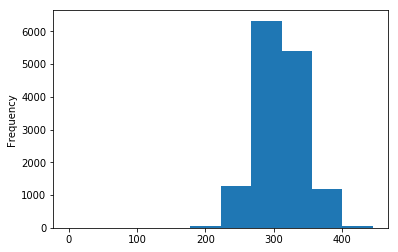

In [25]:
%matplotlib inline
df.dropna().length.plot.hist()